
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fblaura/FraudD/blob/main/4_Supervised_models/1_Model_training_for_dataset_with_StandardScaler_and_SMOTE0_1.ipynb)

**Please execute all instructions as indicated.** 

The dataset is downloaded directly from a Drive link, this dataset already went through a previous preprocessing.We will work on supervised training with the parameters set using GridSearch for the GradientBoosting and XGBoost models, as well as use some plots and metrics to evaluate training and prediction behavior.

**Some functions and graphs are mentioned in Spanish, please translate them if required.**

# **1. General libraries**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pickle
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Normalizer, StandardScaler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from sklearn.feature_selection import SelectFromModel, RFECV, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, cross_val_predict, validation_curve
from datetime import datetime
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, f1_score,plot_roc_curve, classification_report,log_loss,recall_score,adjusted_rand_score


In [ ]:
#from sklearn.metrics import rand_score


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, learning_curve, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix, roc_curve,precision_score,roc_auc_score

In [ ]:
from sklearn.decomposition import PCA,  IncrementalPCA, FastICA
from sklearn.neighbors import KNeighborsClassifier
# Randomization
from sklearn.cluster import KMeans # Our clustering algorithm
from sklearn.metrics import silhouette_samples, silhouette_score,jaccard_score
from sklearn.metrics import pairwise_distances_argmin_min
import random

# **2. Defining different functions**

In [ ]:
def roc_curve_plot(model,model_name,ytest,xtest):
  pred_prob = model.predict_proba(xtest)
  fpr, tpr, thresh = roc_curve(ytest, pred_prob[:,1], pos_label=1)
  # roc curve for tpr = fpr 
  random_probs = [0 for i in range(len(ytest))]
  p_fpr, p_tpr, _ = roc_curve(ytest, random_probs, pos_label=1)
  #plot
  plt.style.use('seaborn')
  auc=roc_auc_score(ytest, pred_prob[:,1])
  # plot roc curves
  plt.plot(fpr, tpr,linewidth=3, linestyle='--',color='orange', label="AUC="+str(auc))
  plt.plot(p_fpr, p_tpr, linewidth=3, linestyle='--', color='blue')
  # title
  plt.title('ROC curve')
  # x label
  plt.xlabel('False Positive Rate')
  # y label
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()
  return plt

In [ ]:
#Función definida para gráficar el análisis de silueta 
# ==============================================================================

def silhouette_analysis(X, range_n_clusters):
    #range_n_clusters = [10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21]

    
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 1 columns
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(19, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters,  max_iter = 300, n_init = 10, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


        plt.suptitle(("Silhouette analysis for %s clustering on sample data "
                      "with n_clusters = %d, score = %.3f" % (clusterer.__class__.__name__, n_clusters,silhouette_avg)),
                     fontsize=14, fontweight='bold')

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """
    
    plt.style.use('seaborn')
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
def impresión_reporte(nclusters,Y,labels):
  
  print(f'Reporte de métricas para KMeans con clusters = {nclusters}')
  print('-'*80)
  print(f'Log_loss = {log_loss(Y, labels)}')
  print(f'Puntuación de exactitud = {accuracy_score(Y, labels)}')
  print(f'Puntuación de sensibilidad = {recall_score(Y, labels)}')
  print(f'Puntuación de precisión = {precision_score(Y, labels)}')
  print(f'Puntuación de Rand ajustado = {adjusted_rand_score(Y, labels)}')
  print(f'Puntuación de Jaccard = {jaccard_score(Y, labels)}')
  cmtx = pd.DataFrame(
      confusion_matrix(Y, labels, labels=[1, 0]), 
      index=['Fraude:1', 'NoFraude:0'], 
      columns=['Fraude:1', 'NoFraude:0']
  )
  print('Matriz de confusión = ')
  print(cmtx)

In [ ]:
def classifier_model(X_train, X_test, y_train, y_test, method, data):
    accuracies, roc_auc,f1=[],[],[]
    modelos=['Random Forest','Gradient Boosting','XGBoost','Regresión logística','Naive Bayes','SVM']
    rf_clf=RandomForestClassifier(n_estimators=700, random_state=1)
    rf_clf.fit(X_train, y_train)
    y_pred_rf=rf_clf.predict(X_test)
    score_rlf=accuracy_score(y_test, y_pred_rf)
    roc_auc_rlf=roc_auc_score(y_test, y_pred_rf)
    f1_sco=f1_score(y_test, y_pred_rf,average='macro')
    accuracies.append(score_rlf)
    roc_auc.append(roc_auc_rlf)
    f1.append(f1_sco)
    print("---Método de trabajo: {}---". format(method))
    print("---Observando comportamiendo de métricas para {}---".format(data))
    print("The accuracy score of Random Forest:", score_rlf)
    print("The ROC_AUC score of Random Forest:", roc_auc_rlf)
    print("The F1 score of Random Forest:", f1_sco)
    print('---------------------------------------------------')
    
    gb_clf= GradientBoostingClassifier(learning_rate=0.1, n_estimators=700,  max_depth=20, max_features=15, subsample=0.7, min_samples_leaf= 3, min_samples_split= 2)
    gb_clf.fit(X_train, y_train)
    y_pred_gb=gb_clf.predict(X_test)
    score_gb=accuracy_score(y_test, y_pred_gb)
    roc_auc_gb=roc_auc_score(y_test,  y_pred_gb)
    f1_sco_gb=f1_score(y_test, y_pred_gb,average='micro')
    accuracies.append(score_gb)
    roc_auc.append(roc_auc_gb)
    f1.append(f1_sco_gb)
    print("The accuracy score of Gradient Boosting:", score_gb)
    print("The ROC_AUC score of Gradient Boosting:", roc_auc_gb)
    print("The F1 score of Gradient Boosting:", f1_sco_gb)

    print('---------------------------------------------------')
    xg_clf=XGBClassifier()
    xg_clf.fit(X_train, y_train)
    y_pred_xg=xg_clf.predict(X_test)
    score_xg=accuracy_score(y_test, y_pred_xg)
    roc_auc_xg=roc_auc_score(y_test, y_pred_xg)
    f1_sco_xg=f1_score(y_test, y_pred_xg,average='micro')
    accuracies.append(score_xg)
    roc_auc.append(roc_auc_xg)
    f1.append(f1_sco_xg)
    print("The accuracy score of XGBoost:", score_xg)
    print("The ROC_AUC score of XGBoost:", roc_auc_xg)
    print("The F1 score of XGBoost:", f1_sco_xg)
    print('---------------------------------------------------')
    clf = LogisticRegression(random_state=0, max_iter=5000)
    clf.fit(X_train, y_train)
    y_pred_l=clf.predict(X_test)
    score_l=accuracy_score(y_test, y_pred_l)
    roc_auc_l=roc_auc_score(y_test, y_pred_l)
    f1_sco_l=f1_score(y_test, y_pred_l,average='micro')
    accuracies.append(score_l)
    roc_auc.append(roc_auc_l)
    f1.append(f1_sco_l)
    print("The accuracy score of Regresión logística:", score_l)
    print("The ROC_AUC score of Regresión logística:", roc_auc_l)  
    print("The F1 score of Regresión logística:", f1_sco_l)
    print('---------------------------------------------------')
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred_gnb=gnb.predict(X_test)
    score_gnb=accuracy_score(y_test, y_pred_gnb)
    roc_auc_gnb=roc_auc_score(y_test, y_pred_gnb)
    f1_sco_gnb=f1_score(y_test, y_pred_gnb,average='micro')
    accuracies.append(score_gnb)
    roc_auc.append(roc_auc_gnb)
    f1.append(f1_sco_gnb)
    print("The accuracy score of Naive Bayes:", score_gnb)
    print("The ROC_AUC score of Naive Bayes:", roc_auc_gnb)   
    print("The F1 score of Naive Bayes:", f1_sco_gnb)
    print('---------------------------------------------------')
    svc=LinearSVC()
    svc.fit(X_train, y_train)
    y_pred_svc=svc.predict(X_test)
    score_svc=accuracy_score(y_test, y_pred_svc)
    roc_auc_svc=roc_auc_score(y_test, y_pred_svc)
    f1_sco_svc=f1_score(y_test, y_pred_svc,average='micro')
    accuracies.append(score_svc)
    roc_auc.append(roc_auc_svc)
    f1.append(f1_sco_svc)
    print("The accuracy score of SVM:", score_svc)
    print("The ROC_AUC score of SVM:", roc_auc_svc)  
    print("The F1 score of Naive Bayes:", f1_sco_svc)
    return  accuracies, roc_auc,f1, modelos

In [ ]:
def autolabel(rects):
    for rect in rects:
        
        width = rect.get_width()
        plt.text(1.05*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
                 '%.2f' % float(width),
                 ha='center', va='center')

In [ ]:
def labels(rects):
  for p in rects.patches:
    ax.annotate(np.round(p.get_height(),decimals=2),((p.get_x()-0.15)+p.get_width(), p.get_height()+2),ha='center',va='center')

# **3. Dataset definition**

In [ ]:
from google.colab import files

In [ ]:
#train_fill
!gdown --id 10lD33nbEwBF7XpgQiVRfWzO2Y0pUY3nA

Downloading...
From: https://drive.google.com/uc?id=10lD33nbEwBF7XpgQiVRfWzO2Y0pUY3nA
To: /content/X_trainss_01.csv
100% 686M/686M [00:04<00:00, 163MB/s]


In [ ]:
X_trainss_01 = pd.read_csv('/content/X_trainss_01.csv',error_bad_lines=False)

b'Skipping line 74954: expected 432 fields, saw 489\n'


In [ ]:
X_trainss_01

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_35,id_36,id_37,id_38,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,CurrencyCents,CurrencyDollar,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32,MobileCompareSerial,TransactionID,TransactionDT,card1,CentsDigits,isFraud
0,0.73600,-2.438198,-1.421715,-0.341023,-0.083186,0.0,0.186352,0.281360,2.922440,-0.423689,1.640759,-0.158137,-0.265768,0.160981,0.217591,-0.457419,0.447464,0.072847,-0.003701,-0.435635,-0.446449,0.326466,-0.167966,0.292131,0.278315,-0.286590,0.041363,-0.274044,-1.448447,0.229787,0.168792,-0.124002,-0.097562,-0.137700,-0.139046,-0.103497,-0.129767,-0.201776,-0.148080,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.061457,-0.085408,-0.085009,-0.086519,0.516788,-0.287635,0.137939,-0.164430,-0.063159,0.038139,-0.207028,0.207908,0.005474,0.027114,-0.060995,0.052452,0.150306,0.216116,0.250989,-0.269621,0.186871,-0.042122,0.019665,-0.068128,-0.030527,0.071963,-0.007271,-0.008259,-0.295907,-0.266837,-1.732027,-1.756537,0.818050,-0.670784,0
1,0.73600,-0.904898,-1.421715,-0.341023,-0.083186,0.0,0.186352,0.281360,-0.411229,2.360224,1.640759,-0.158137,-0.265768,0.160981,0.217591,-0.457419,0.447464,0.072847,-0.003701,-0.435635,-0.446449,0.326466,-0.167966,0.292131,0.278315,-0.478321,0.224814,-0.274044,-2.435659,0.329704,0.168792,-0.168789,-0.097562,-0.137700,-0.139046,-0.103497,-0.129767,-0.201776,-0.148080,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.061457,-0.085408,-0.085009,-0.086519,-0.713841,-0.476956,0.137939,-0.164430,-0.063159,0.038139,-0.207028,0.207908,0.005474,0.027114,-0.060995,0.052452,0.150306,0.216116,0.250989,-0.269621,0.186871,-0.042122,0.019665,-0.068128,-0.030527,0.071963,-0.007271,-0.008259,-0.295907,-0.266837,-1.731980,-1.756535,-1.451410,-0.670784,0
2,0.73600,0.628401,0.702593,0.842275,-0.083186,0.0,0.186352,0.281360,-0.411229,-0.423689,-0.609474,-0.158137,-0.265768,-6.211912,0.217591,-0.457419,0.447464,0.072847,-0.003701,-0.435635,-0.446449,0.326466,-0.167966,0.292131,0.278315,-0.332703,0.768843,-0.274044,-0.856119,0.379663,0.168792,1.076299,-0.097562,-0.137700,-0.139046,-0.103497,-0.129767,-0.201776,-0.148080,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.061457,-0.085408,-0.085009,-0.086519,-0.713841,-0.331325,0.137939,-0.164430,-0.063159,0.038139,-0.207028,0.207908,0.005474,0.027114,-0.060995,0.052452,0.150306,0.216116,0.250989,-0.269621,0.186871,-0.042122,0.019665,-0.068128,-0.030527,0.071963,-0.007271,-0.008259,-0.295907,-0.266837,-1.731932,-1.756384,-1.063787,-0.670784,0
3,0.73600,-0.904898,0.702593,1.963293,-0.083186,0.0,0.186352,0.281360,-0.411229,2.360224,-0.609474,-0.158137,-0.265768,0.160981,0.217591,-0.457419,0.447464,0.072847,-0.003701,-0.435635,-0.446449,0.326466,-0.167966,0.292131,0.278315,-0.376388,1.255938,-0.274044,-2.065454,1.838456,0.168792,-0.168789,-0.097562,-0.134878,-0.129379,-0.103497,-0.129767,-0.201776,-0.131187,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.061457,-0.085408,-0.085009,-0.086519,-0.713841,-0.375014,0.137939,-0.164430,-0.063159,0.038139,-0.207028,0.207908,0.005474,0.027114,-0.060995,0.052452,0.150306,0.216116,0.250989,-0.269621,0.186871,-0.042122,0.019665,-0.068128,-0.030527,0.071963,-0.007271,-0.008259,-0.295907,-0.266837,-1.731885,-1.756318,1.672526,-0.670784,0
4,-1.25103,-0.904898,-1.421715,-0.341023,-0.083186,0.0,0.186352,0.281360,-0.411229,-0.423689,-0.609474,-0.158137,-0.265768,0.160981,0.217591,1.747812,0.447464,0.072847,-0.003701,2.295501,2.239898,0.326466,-0.167966,0.292131,0.278315,-0.376388,0.920665,-0.274044,-2.435659,1.278919,0.168792,-0.168789,-0.097562,-0.137700,-0.139046,-0.103497,-0.129767,-0.201776,-0.148080,-0.120759,...,-0.097634,-0.081114,-0.102326,-0.045128,-0.070983,-0.

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
Y = X_trainss_01['isFraud']
X = X_trainss_01.drop(['isFraud', 'TransactionID'], axis=1)

In [ ]:
target_n=pd.unique(Y)
target_n

array([0, 1])

# **4. Training with GradientBoosting**




As mentioned above, a hyperparameter fitting process was performed with GridSearch, obtaining the arguments for each model that optimized the performance at the time of training. In order to compare the training from the beginning to when it is done with GridSearch, this section is performed. 

In case you want to observe the hyperparameter setting with GridSearch you can go to the following repository folder. 

[GridSearch tuning](https://github.com/fblaura/FraudD/tree/main/3_GridSearch)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, random_state=42, stratify=Y)

In [ ]:
model1 = GradientBoostingClassifier(random_state=40, learning_rate=0.1, n_estimators=700,  max_depth=20, max_features=15, subsample=0.7, min_samples_leaf= 3, min_samples_split= 2)
model1.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=20,
                           max_features=15, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=700,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=40, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
pickle.dump(model1, open("gbm_ss01.pickle.dat", "wb"))

The next section includes the evaluation of a score by cross-validation. In this case, the model is trained using n number of folds as training data, the resulting model is then validated on the remaining data.
And is a process that is repeated n times and performance metric such as "F1" is computed at each step.

In [ ]:
scores=cross_val_score(model1, X_train, y_train, cv=8, scoring='f1_micro')

In [ ]:
print("%0.2f de coeficiente F1 con una desviación estándar de %0.2f" % (scores.mean(), scores.std()))

0.99 de coeficiente F1 con una desviación estándar de 0.00


In [ ]:
scores

array([0.98660287, 0.98523582, 0.9848257 , 0.98537252, 0.98673958,
       0.98619087, 0.98537052, 0.98619087])

However, the previous Scikit-Learn function only allows to evaluate on a single metric of choice, for that reason the following function is used to evaluate on a set of metrics, such as: precision, F1, AUC and code execution time.

In [ ]:
scoring = ['roc_auc', 'accuracy','f1_micro']

scores2 = cross_validate(model1, X_train, y_train, scoring=scoring, cv=8)

In [ ]:
scores2

{'fit_time': array([60.0794673 , 61.73696804, 60.86190295, 59.66032195, 59.85227919,
        61.87305117, 60.79682255, 60.98428297]),
 'score_time': array([0.58479095, 0.55609393, 0.5391016 , 0.62986231, 0.61890197,
        0.55475783, 0.55029535, 0.56286693]),
 'test_accuracy': array([0.98660287, 0.98523582, 0.9848257 , 0.98537252, 0.98673958,
        0.98619087, 0.98537052, 0.98619087]),
 'test_f1_micro': array([0.98660287, 0.98523582, 0.9848257 , 0.98537252, 0.98673958,
        0.98619087, 0.98537052, 0.98619087]),
 'test_roc_auc': array([0.9950627 , 0.9911212 , 0.98481535, 0.99285262, 0.99442771,
        0.99205903, 0.99249157, 0.99377589])}

## **A. Graphics with GradientBoosting**

With the information obtained by the cross validation function, the following graph is made (taking into account the number of splits granted for the validation)

In [ ]:
cv=range(1,9)
fit_time=scores2['fit_time']
score_time=scores2['score_time']
test_accuracy=[k*100 for k in scores2['test_accuracy']]
test_f1_micro=[k*100 for k in scores2['test_f1_micro']]
test_roc_auc=[k*100 for k in scores2['test_roc_auc']]


Text(68.625, 0.5, '%')

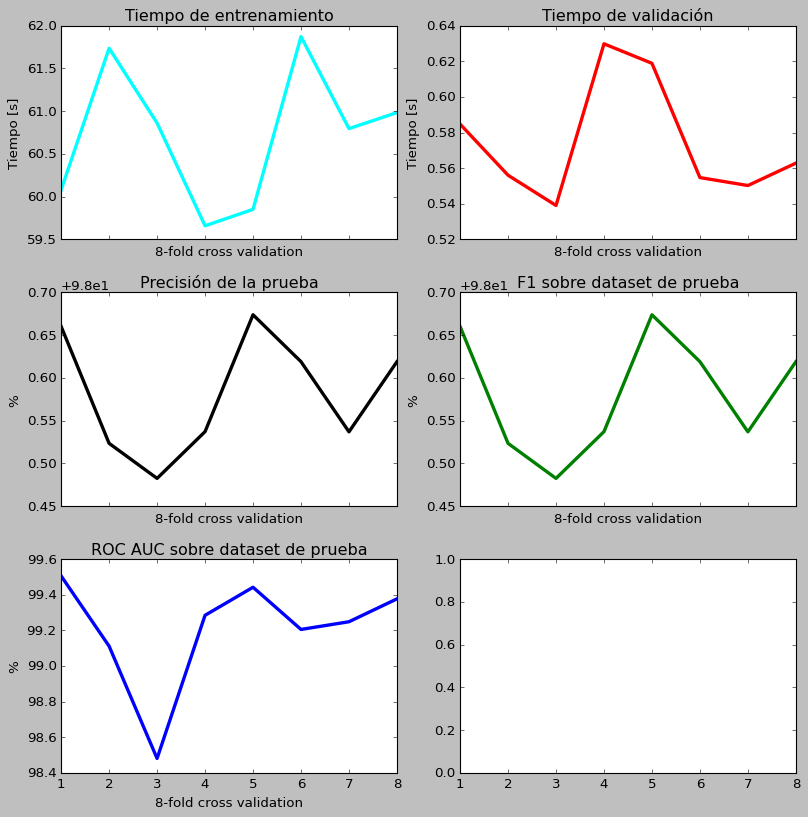

In [ ]:
plt.style.use('classic')
# Create subplots
fig, ax = plt.subplots(3, 2,figsize=(10,10), sharex=True)
fig.tight_layout(h_pad=3, w_pad=2)

ax[0][0].plot(cv,fit_time, linewidth=3, color='cyan')
ax[0][1].plot(cv,score_time, linewidth=3, color='red')
ax[1][0].plot(cv,test_accuracy, linewidth=3, color='black')
ax[1][1].plot(cv,test_f1_micro,linewidth=3, color='green')
ax[2][0].plot(cv,test_roc_auc,linewidth=3, color='blue')
#------1
ax[0][0].title.set_text('Tiempo de entrenamiento')
ax[0][0].set_xlabel('8-fold cross validation')
ax[0][0].set_ylabel('Tiempo [s]')
#------2
ax[0][1].title.set_text('Tiempo de validación')
ax[0][1].set_xlabel('8-fold cross validation')
ax[0][1].set_ylabel('Tiempo [s]')
#------3
ax[1][0].title.set_text('Precisión de la prueba')
ax[1][0].set_xlabel('8-fold cross validation')
ax[1][0].set_ylabel('%')
#------4
ax[1][1].title.set_text('F1 sobre dataset de prueba')
ax[1][1].set_xlabel('8-fold cross validation')
ax[1][1].set_ylabel('%')
#------5
ax[2][0].title.set_text('ROC AUC sobre dataset de prueba')
ax[2][0].set_xlabel('8-fold cross validation')
ax[2][0].set_ylabel('%')

The ROC-AUC curve (which is a requirement of the Kaggle competition) is also plotted. We observe that for our exercise it presents a score above 98%.

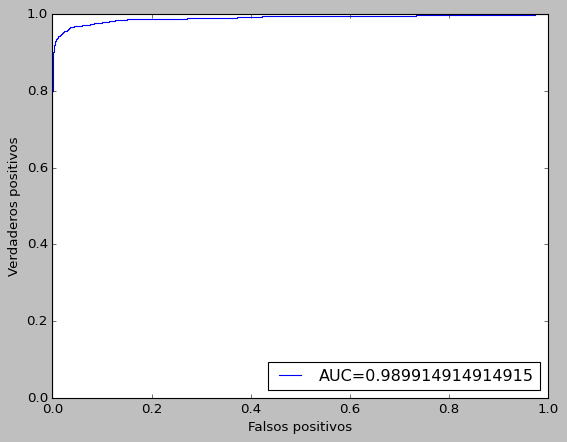

In [ ]:
y_pred_proba = model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.legend(loc=4)
plt.show()

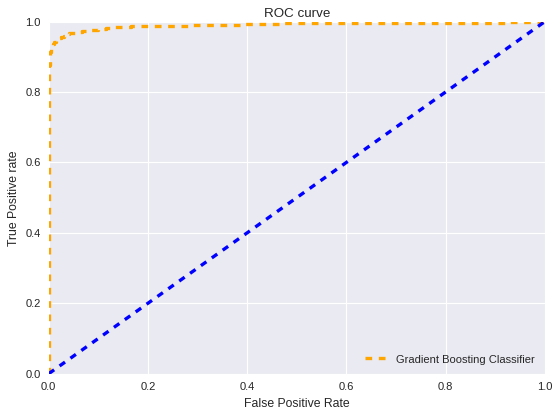

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
roc_curve_plot(model=model1,model_name='Gradient Boosting Classifier', ytest=y_test, xtest=X_test)

With learning curves is possible to view the error changes along training evaluated according the training set size increases. The evaluation according to training set sizes is performed through cross-validation 

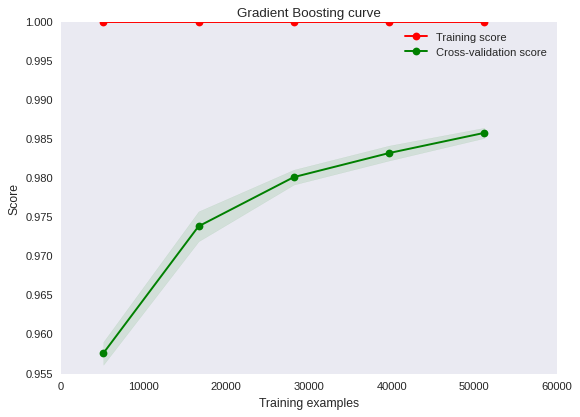

In [ ]:
plot_learning_curve(estimator = model1,title = "Gradient Boosting curve",
                    X = X_train, y = y_train, cv = 8);

In [ ]:
train_sizes = [500, 2000, 5000, 7000,10000, 13000]
train_sizes, train_scores, validation_scores = learning_curve(model1, X_test, y_test, train_sizes = train_sizes, cv = 5,scoring = 'roc_auc')

In [ ]:
print('Puntaje ROC entrenamiento:\n\n', train_scores)
print('\n', '-' * 70) 
print('\nPuntaje ROC validaciónes:\n\n', validation_scores)

Puntaje ROC entrenamiento:

 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]

 ----------------------------------------------------------------------

Puntaje ROC validaciónes:

 [[0.7191542  0.85033171 0.85526456 0.84967668 0.87810007]
 [0.89512629 0.90100819 0.90664931 0.90754472 0.9250021 ]
 [0.94226673 0.94064363 0.95688211 0.95175808 0.95271077]
 [0.95483832 0.95319316 0.96856527 0.96633399 0.96320246]
 [0.96547458 0.96056703 0.97638765 0.97301653 0.97245428]
 [0.96832127 0.96736574 0.97482511 0.97844791 0.96709953]]


In [ ]:
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis =1 )
print('Media del puntaje de entrenamiento\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMedia del puntaje de validación\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Media del puntaje de entrenamiento

 500      1.0
2000     1.0
5000     1.0
7000     1.0
10000    1.0
13000    1.0
dtype: float64

 --------------------

Media del puntaje de validación

 500      0.830505
2000     0.907066
5000     0.948852
7000     0.961227
10000    0.969580
13000    0.971212
dtype: float64


If we observe this learning curve we obtain that it presents a low variance caused by the small gap between the curves obtained for training and validation. In this case, we observe that both have a good behavior since they were evaluated with ROC - AUC, obtaining scores above 90% as the training size increases. 

(0.0, 2.0)

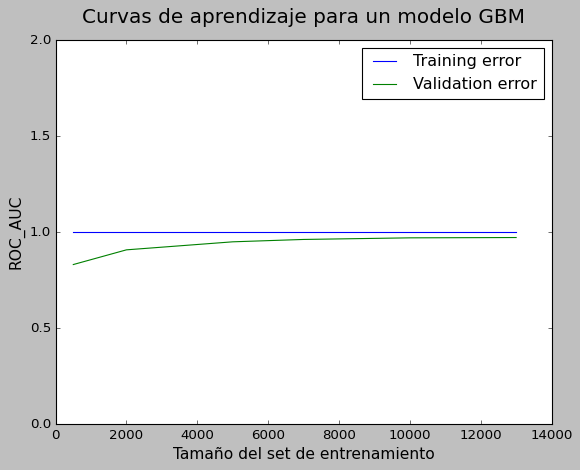

In [ ]:
plt.style.use('classic')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('ROC_AUC', fontsize = 14)
plt.xlabel('Tamaño del set de entrenamiento', fontsize = 14)
plt.title('Curvas de aprendizaje para un modelo GBM', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,2)

With the confusion matrix we can observe more clearly the prediction of the different labels. In this case we see that with GradientBoosting we obtain a prediction above 80%, which indicates a good prediction, however it is necessary to improve the model so that it does not have such a large error range. 

In [ ]:
predic=model1.predict(X_test)
cm = confusion_matrix(y_test, predic)

In [ ]:
cm_percentage = np.array([[ 99.94, 0.06],[ 16.67, 83.33]])

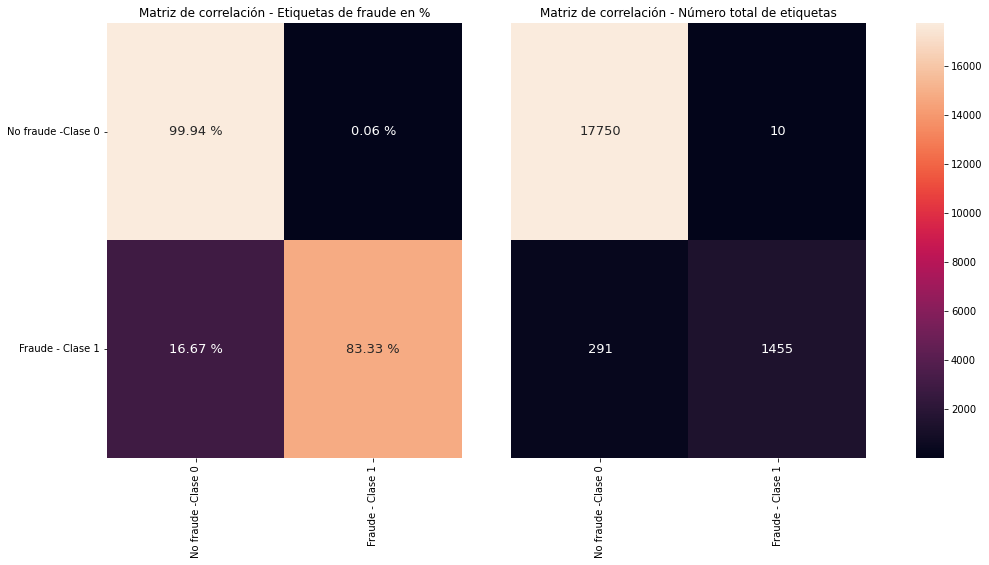

In [ ]:
x_axis_labels = ['No fraude -Clase 0', 'Fraude - Clase 1'] # labels for x-axis
y_axis_labels = ['No fraude -Clase 0', 'Fraude - Clase 1'] # labels for y-axis
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
            gridspec_kw={'width_ratios':[1,1,0.08]},figsize=(15,8))
ax1.get_shared_y_axes().join(ax1,ax2)
map1=sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap="rocket", xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=False,ax=ax1, annot_kws={"fontsize":13})
for t in map1.texts: t.set_text(t.get_text() + " %")
map1.set_ylabel('')
map1.set_xlabel('')
map1.title.set_text('Matriz de correlación - Etiquetas de fraude en %')
map2=sns.heatmap(cm, annot=True, fmt='d', cmap="rocket", xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax2, annot_kws={"fontsize":13}, cbar_ax=axcb )
map2.set_ylabel('')
map2.set_xlabel('')
map2.set_yticks([])
map2.title.set_text('Matriz de correlación - Número total de etiquetas')

for ax in [map1,map2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.show()

In [ ]:
y_test.value_counts()

0    17760
1     1746
Name: isFraud, dtype: int64

In [ ]:
print(accuracy_score(y_test, predic))

0.9845688506100687


We also see the distribution of the number of records in order to observe the number of misclassified labels.

In [ ]:
y_pred_prob = model1.predict_proba(X_test)[:, 1]

In [ ]:
ypfv=model1.predict_proba(X_test)

In [ ]:
y_pred_prob[y_test==1]

array([9.98794153e-01, 3.22459499e-01, 9.99803762e-01, ...,
       1.24575049e-05, 3.51174063e-01, 9.98195310e-01])

In [ ]:
totalfraud=y_pred_prob[y_test==1]

In [ ]:
fraudmore05 = totalfraud[np.where(totalfraud > 0.5)]
fraudless05 = totalfraud[np.where(totalfraud < 0.5)]

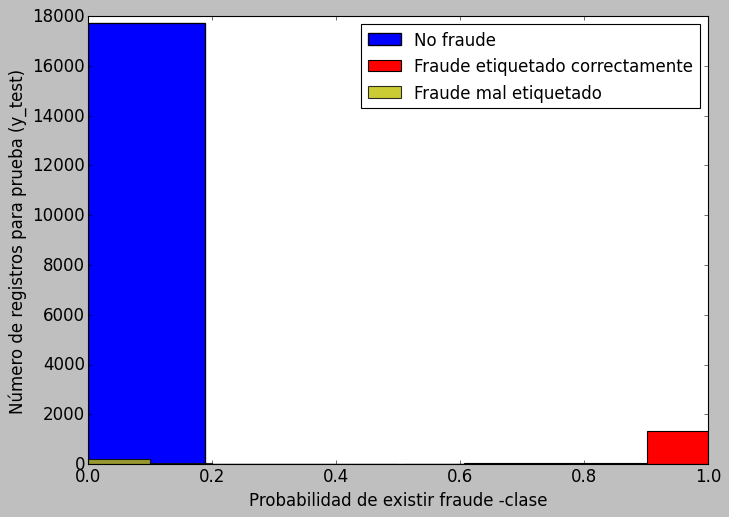

In [ ]:
plt.style.use('classic')

plt.figure(figsize=(10,7))
plt.hist(y_pred_prob[y_test==0], bins=5, label='No fraude', color='b', edgecolor='black',  linewidth=1.2)
plt.hist(fraudmore05, bins=5, label='Fraude etiquetado correctamente', color='r')
plt.hist(fraudless05, bins=5, label='Fraude mal etiquetado', alpha=0.8, color='y')
plt.xlabel('Probabilidad de existir fraude -clase', fontsize=15)
plt.ylabel('Número de registros para prueba (y_test)', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=3)
plt.show() 

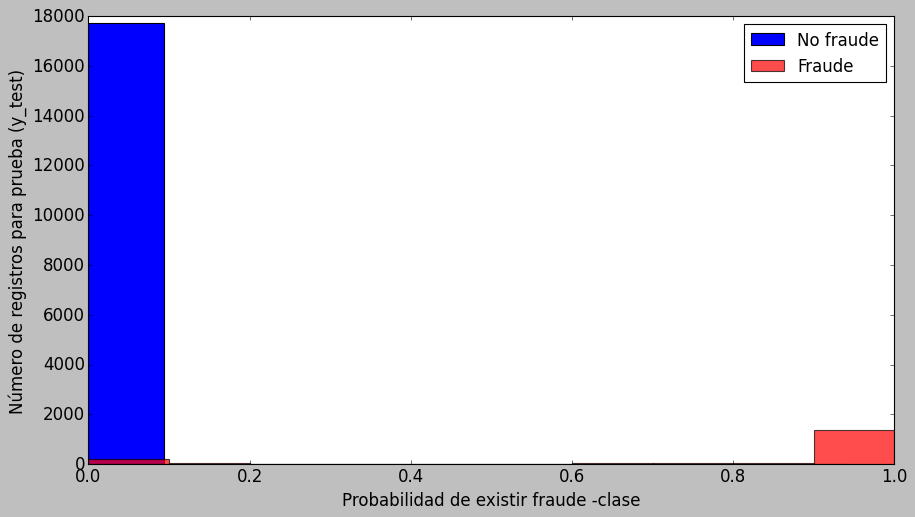

In [ ]:
plt.style.use('classic')

plt.figure(figsize=(13,7))
plt.hist(y_pred_prob[y_test==0], bins=10, label='No fraude')
plt.hist(y_pred_prob[y_test==1], bins=10, label='Fraude', alpha=0.7, color='r')
plt.xlabel('Probabilidad de existir fraude -clase', fontsize=15)
plt.ylabel('Número de registros para prueba (y_test)', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=3)
plt.show() 

In [ ]:
plt.style.use('default')


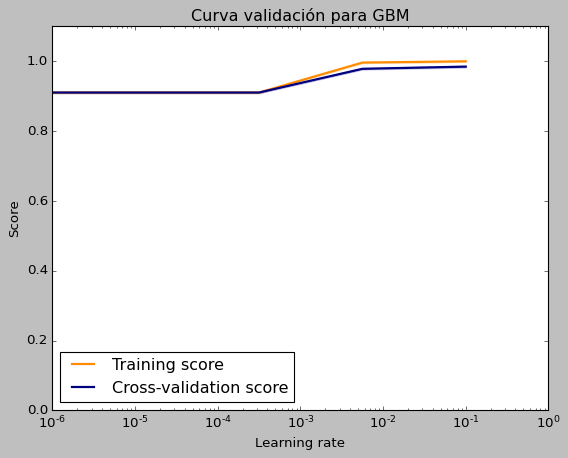

In [ ]:
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    model1, X_train, y_train, param_name="learning_rate", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Curva validación para GBM")
plt.xlabel(r"Learning rate")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [ ]:
##def display(results):
##    print(f'Best parameters are: {results.best_params_}')
##    print("\n")
##    mean_score = results.cv_results_['mean_test_score']
##    std_score = results.cv_results_['std_test_score']
##    params = results.cv_results_['params']
##    for mean,std,params in zip(mean_score,std_score,params):
##        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

Finally, the importance of the features for GradientBoosting is plotted. It is possible to observe how the variables realized from feature engineering are among the most important variables. 

Precisión de GBM en el dataset de prueba: 0.985
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17760
           1       0.99      0.83      0.91      1746

    accuracy                           0.98     19506
   macro avg       0.99      0.92      0.95     19506
weighted avg       0.98      0.98      0.98     19506



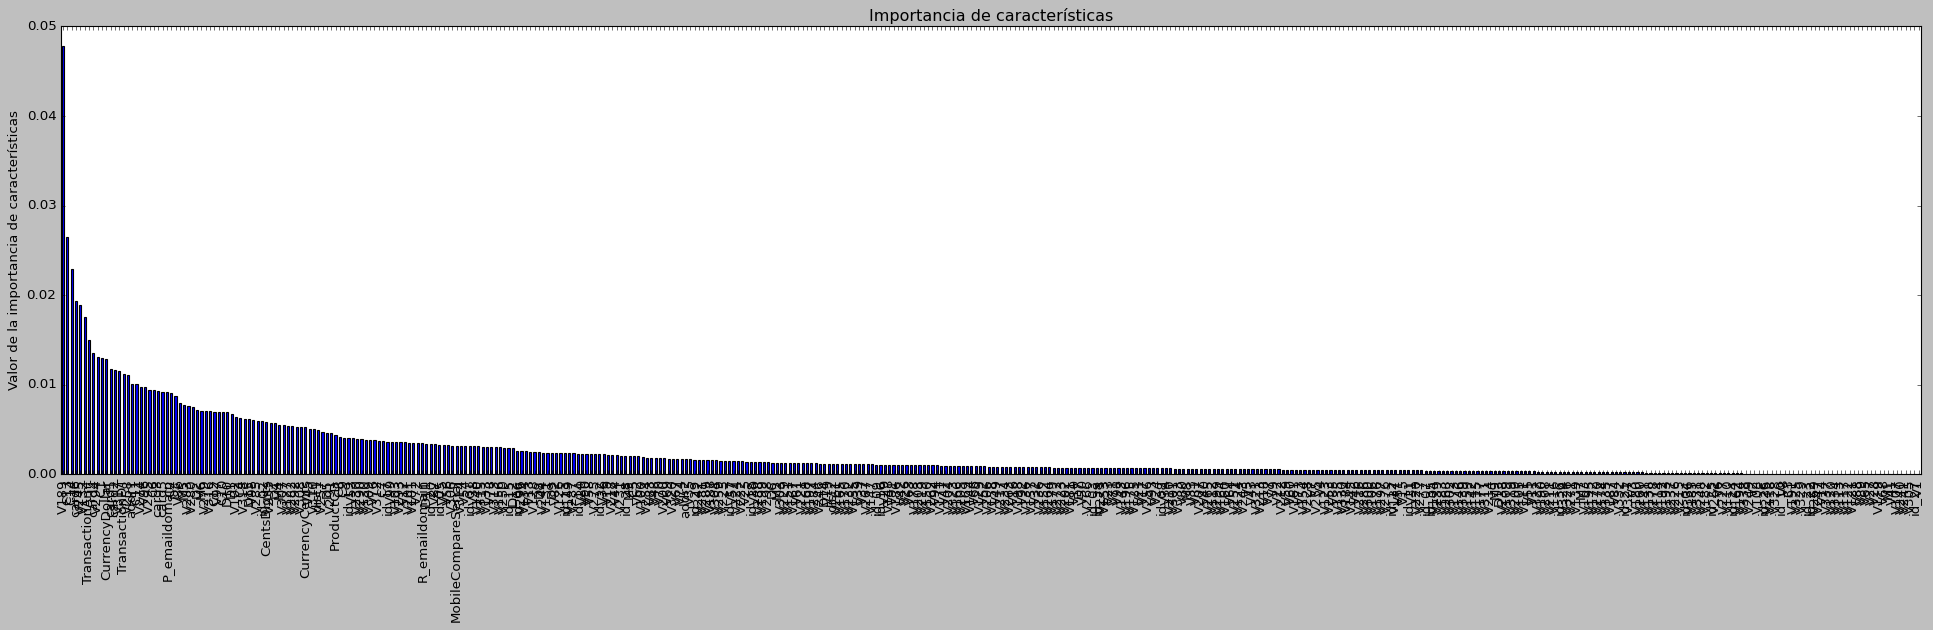

In [ ]:
plt.figure(figsize=(30,7))

predictors=list(X_train)
feat_imp = pd.Series(model1.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importancia de características')
plt.ylabel('Valor de la importancia de características')
print('Precisión de GBM en el dataset de prueba: {:.3f}'.format(model1.score(X_test, y_test)))
pred=model1.predict(X_test)
#print(classification_report(y_test, pred))

# **5. Training with XGBoost**

The above process is repeated iteratively for the XGBoost model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, random_state=42, stratify=Y)

In [ ]:
model2=XGBClassifier(eta=0.01,scale_pos_weight = 1,reg_alpha= 0.05, stopping_metric='log_loss',keep_cross_validation_predictions=True, objective='binary:logistic', nfolds=3, seed= -1,max_depth= 15,gamma=0.0,colsample_bytree =0.6,subsample=0.6)
model2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eta=0.01, gamma=0.0,
              keep_cross_validation_predictions=True, learning_rate=0.1,
              max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nfolds=3, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0.05,
              reg_lambda=1, scale_pos_weight=1, seed=-1, silent=None,
              stopping_metric='log_loss', subsample=0.6, verbosity=1)

In [ ]:
pickle.dump(model2, open("xgb_ss01.pickle.dat", "wb"))

In [ ]:
scores2=cross_val_score(model2, X_train, y_train, cv=8, scoring='f1_micro')

In [ ]:
print("%0.2f de coeficiente F1 con una desviación estándar de %0.2f" % (scores2.mean(), scores2.std()))

0.99 de coeficiente F1 con una desviación estándar de 0.00


In [ ]:
scoring = ['roc_auc', 'accuracy','f1_micro']

scores2 = cross_validate(model1, X_train, y_train, scoring=scoring, cv=8)

In [ ]:
scores2

{'fit_time': array([50.98650527, 51.14251328, 50.31330085, 50.58177066, 51.02947521,
        50.54870224, 50.89666295, 50.55476284]),
 'score_time': array([0.48805547, 0.49147201, 0.47901082, 0.46366215, 0.48752737,
        0.46207285, 0.4780767 , 0.46933198]),
 'test_accuracy': array([0.98660287, 0.98523582, 0.9848257 , 0.98537252, 0.98673958,
        0.98619087, 0.98537052, 0.98619087]),
 'test_f1_micro': array([0.98660287, 0.98523582, 0.9848257 , 0.98537252, 0.98673958,
        0.98619087, 0.98537052, 0.98619087]),
 'test_roc_auc': array([0.9950627 , 0.9911212 , 0.98481535, 0.99285262, 0.99442771,
        0.99205903, 0.99249157, 0.99377589])}

## **A. Graphics with XGBoost**

In [ ]:
cv=range(1,9)
fit_time=scores2['fit_time']
score_time=scores2['score_time']
test_accuracy=[k*100 for k in scores2['test_accuracy']]
test_f1_micro=[k*100 for k in scores2['test_f1_micro']]
test_roc_auc=[k*100 for k in scores2['test_roc_auc']]


Text(68.625, 0.5, '%')

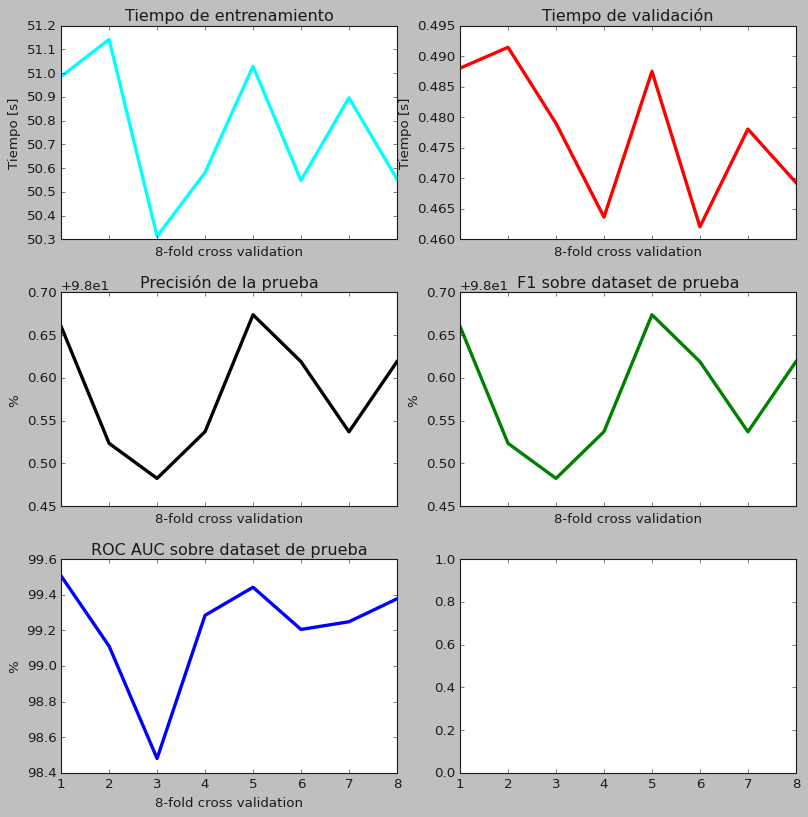

In [ ]:
plt.style.use('classic')
# Create subplots
fig, ax = plt.subplots(3, 2,figsize=(10,10), sharex=True)
fig.tight_layout(h_pad=3, w_pad=2)

ax[0][0].plot(cv,fit_time, linewidth=3, color='cyan')
ax[0][1].plot(cv,score_time, linewidth=3, color='red')
ax[1][0].plot(cv,test_accuracy, linewidth=3, color='black')
ax[1][1].plot(cv,test_f1_micro,linewidth=3, color='green')
ax[2][0].plot(cv,test_roc_auc,linewidth=3, color='blue')
#------1
ax[0][0].title.set_text('Tiempo de entrenamiento')
ax[0][0].set_xlabel('8-fold cross validation')
ax[0][0].set_ylabel('Tiempo [s]')
#------2
ax[0][1].title.set_text('Tiempo de validación')
ax[0][1].set_xlabel('8-fold cross validation')
ax[0][1].set_ylabel('Tiempo [s]')
#------3
ax[1][0].title.set_text('Precisión de la prueba')
ax[1][0].set_xlabel('8-fold cross validation')
ax[1][0].set_ylabel('%')
#------4
ax[1][1].title.set_text('F1 sobre dataset de prueba')
ax[1][1].set_xlabel('8-fold cross validation')
ax[1][1].set_ylabel('%')
#------5
ax[2][0].title.set_text('ROC AUC sobre dataset de prueba')
ax[2][0].set_xlabel('8-fold cross validation')
ax[2][0].set_ylabel('%')

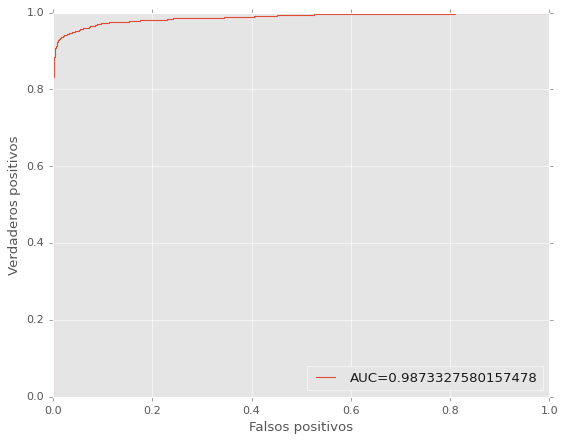

In [ ]:
y_pred_proba = model2.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.legend(loc=4)
plt.show()

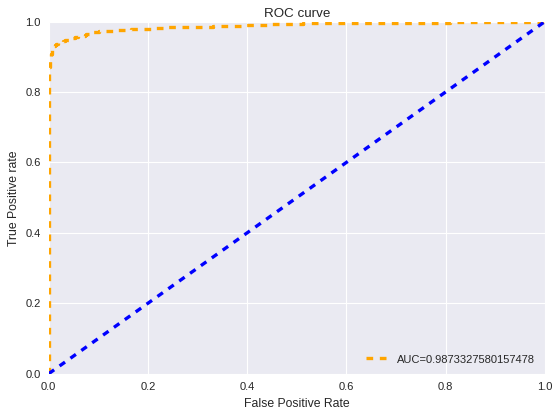

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
roc_curve_plot(model=model2,model_name='XGBoost Classifier', ytest=y_test, xtest=X_test)

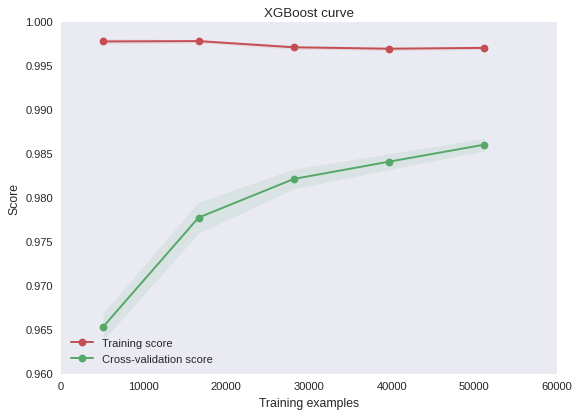

In [ ]:
plot_learning_curve(estimator = model2,title = "XGBoost curve",
                    X = X_train, y = y_train, cv = 8);

In [ ]:
train_sizes = [500, 2000, 5000, 7000,10000, 13000]
train_sizes, train_scores, validation_scores = learning_curve(model2, X_test, y_test, train_sizes = train_sizes, cv = 5,scoring = 'roc_auc')

In [ ]:
print('Puntaje ROC entrenamiento:\n\n', train_scores)
print('\n', '-' * 70) 
print('\nPuntaje ROC validaciónes:\n\n', validation_scores)

Puntaje ROC entrenamiento:

 [[1.         1.         1.         1.         1.        ]
 [0.99998532 1.         1.         1.         1.        ]
 [1.         1.         0.9999864  0.9999864  0.9999864 ]
 [0.999999   1.         0.99999846 0.99999846 0.99999846]
 [0.99999925 0.99999777 0.99998288 0.99999667 0.99999667]
 [0.99997692 0.9999971  0.99999333 0.99998578 0.99999021]]

 ----------------------------------------------------------------------

Puntaje ROC validaciónes:

 [[0.76070383 0.84599177 0.85892528 0.86520044 0.88551347]
 [0.91350869 0.91320359 0.92539334 0.93085376 0.94533852]
 [0.95116554 0.94334521 0.96197711 0.956603   0.96037101]
 [0.96366876 0.95365539 0.96918803 0.96488439 0.96720359]
 [0.96566281 0.96017337 0.97332146 0.97198318 0.96953248]
 [0.9694112  0.96600406 0.9735191  0.97539059 0.97290925]]


In [ ]:
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis =1 )
print('Media del puntaje de entrenamiento\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMedia del puntaje de validación\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Media del puntaje de entrenamiento

 500      1.000000
2000     0.999997
5000     0.999992
7000     0.999999
10000    0.999995
13000    0.999989
dtype: float64

 --------------------

Media del puntaje de validación

 500      0.843267
2000     0.925660
5000     0.954692
7000     0.963720
10000    0.968135
13000    0.971447
dtype: float64


(0.0, 2.0)

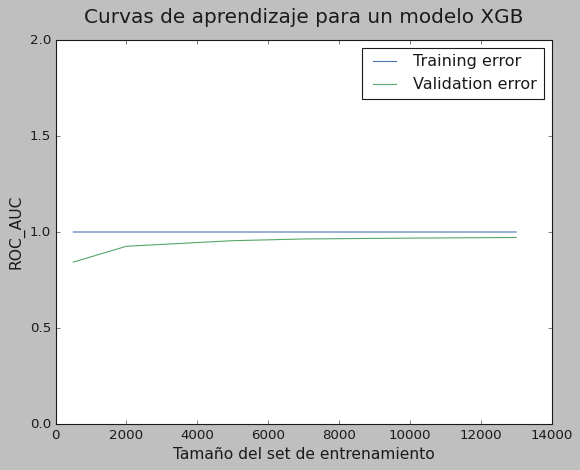

In [ ]:
plt.style.use('classic')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('ROC_AUC', fontsize = 14)
plt.xlabel('Tamaño del set de entrenamiento', fontsize = 14)
plt.title('Curvas de aprendizaje para un modelo XGB', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,2)

In [ ]:
predic=model2.predict(X_test)
cm = confusion_matrix(y_test, predic)

In [ ]:
cm

array([[17747,    13],
       [  273,  1473]])

In [ ]:
y_test.value_counts()

0    17760
1     1746
Name: isFraud, dtype: int64

In [ ]:
cm_percentage = np.array([[ 99.92, 0.08],[ 15.63, 84.36]])

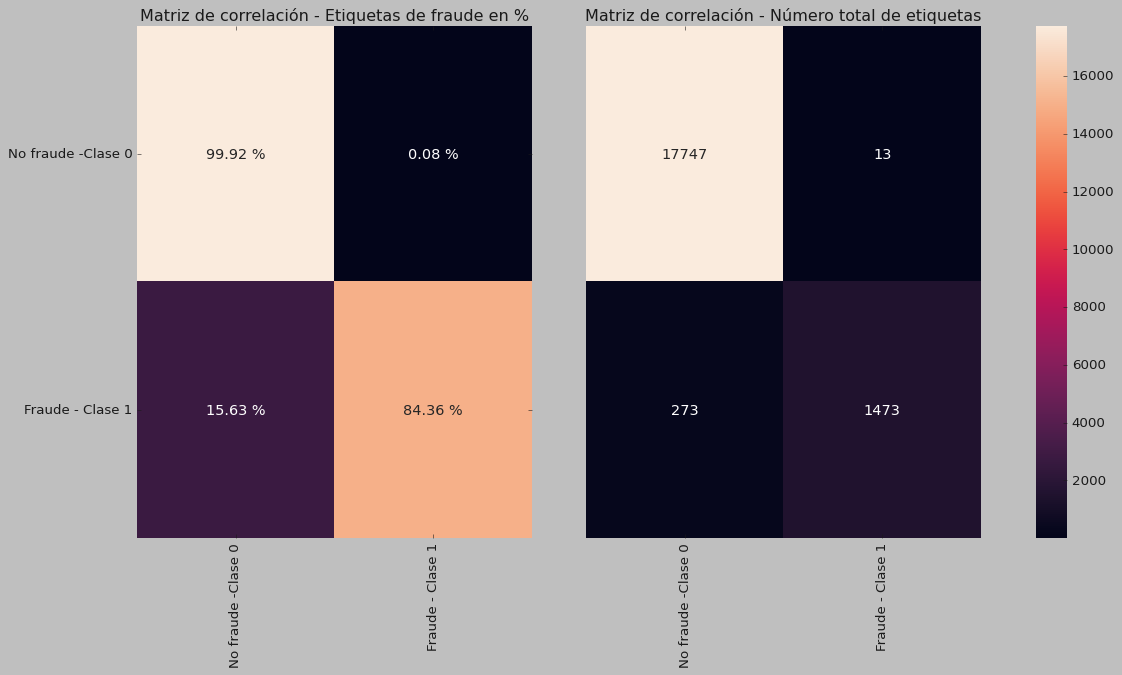

In [ ]:
x_axis_labels = ['No fraude -Clase 0', 'Fraude - Clase 1'] # labels for x-axis
y_axis_labels = ['No fraude -Clase 0', 'Fraude - Clase 1'] # labels for y-axis
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
            gridspec_kw={'width_ratios':[1,1,0.08]},figsize=(15,8))
ax1.get_shared_y_axes().join(ax1,ax2)
map1=sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap="rocket", xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=False,ax=ax1, annot_kws={"fontsize":13})
for t in map1.texts: t.set_text(t.get_text() + " %")
map1.set_ylabel('')
map1.set_xlabel('')
map1.title.set_text('Matriz de correlación - Etiquetas de fraude en %')
map2=sns.heatmap(cm, annot=True, fmt='d', cmap="rocket", xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax2, annot_kws={"fontsize":13}, cbar_ax=axcb )
map2.set_ylabel('')
map2.set_xlabel('')
map2.set_yticks([])
map2.title.set_text('Matriz de correlación - Número total de etiquetas')

for ax in [map1,map2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.show()

In [ ]:
y_test.value_counts()

0    17760
1     1746
Name: isFraud, dtype: int64

In [ ]:
print(accuracy_score(y_test, predic))

0.9853378447657131


In [ ]:
y_pred_prob = model2.predict_proba(X_test)[:, 1]

In [ ]:
ypfv=model2.predict_proba(X_test)

In [ ]:
y_pred_prob[y_test==1]

array([0.97785634, 0.44358757, 0.9981042 , ..., 0.00135294, 0.9319433 ,
       0.9985488 ], dtype=float32)

In [ ]:
totalfraud=y_pred_prob[y_test==1]

In [ ]:
fraudmore05 = totalfraud[np.where(totalfraud > 0.5)]
fraudless05 = totalfraud[np.where(totalfraud < 0.5)]

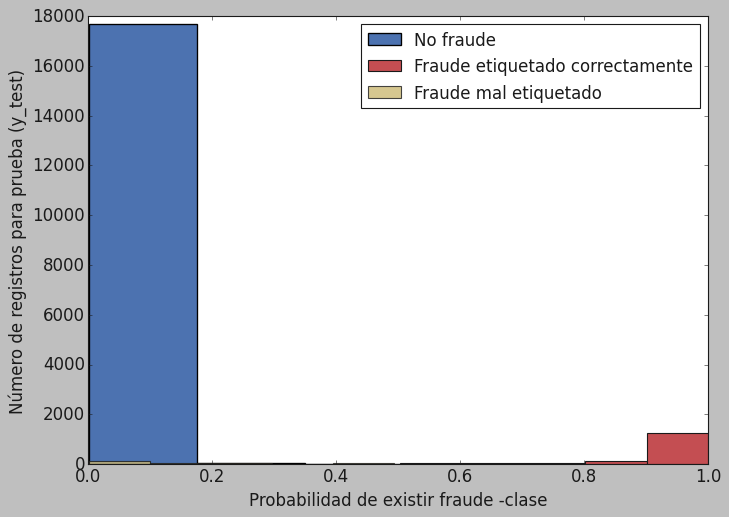

In [ ]:
plt.style.use('classic')

plt.figure(figsize=(10,7))
plt.hist(y_pred_prob[y_test==0], bins=5, label='No fraude', color='b', edgecolor='black',  linewidth=1.2)
plt.hist(fraudmore05, bins=5, label='Fraude etiquetado correctamente', color='r')
plt.hist(fraudless05, bins=5, label='Fraude mal etiquetado', alpha=0.8, color='y')
plt.xlabel('Probabilidad de existir fraude -clase', fontsize=15)
plt.ylabel('Número de registros para prueba (y_test)', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=3)
plt.show() 

In [ ]:
plt.style.use('default')


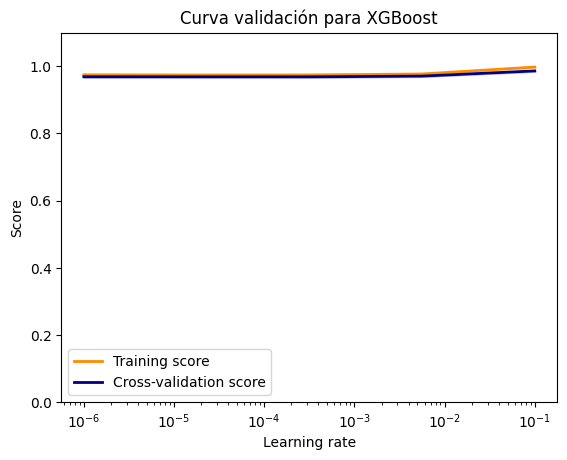

In [ ]:
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    model2, X_train, y_train, param_name="learning_rate", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Curva validación para XGBoost")
plt.xlabel(r"Learning rate")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Precisión de GBM en el dataset de prueba: 0.985
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17760
           1       0.99      0.84      0.91      1746

    accuracy                           0.99     19506
   macro avg       0.99      0.92      0.95     19506
weighted avg       0.99      0.99      0.98     19506



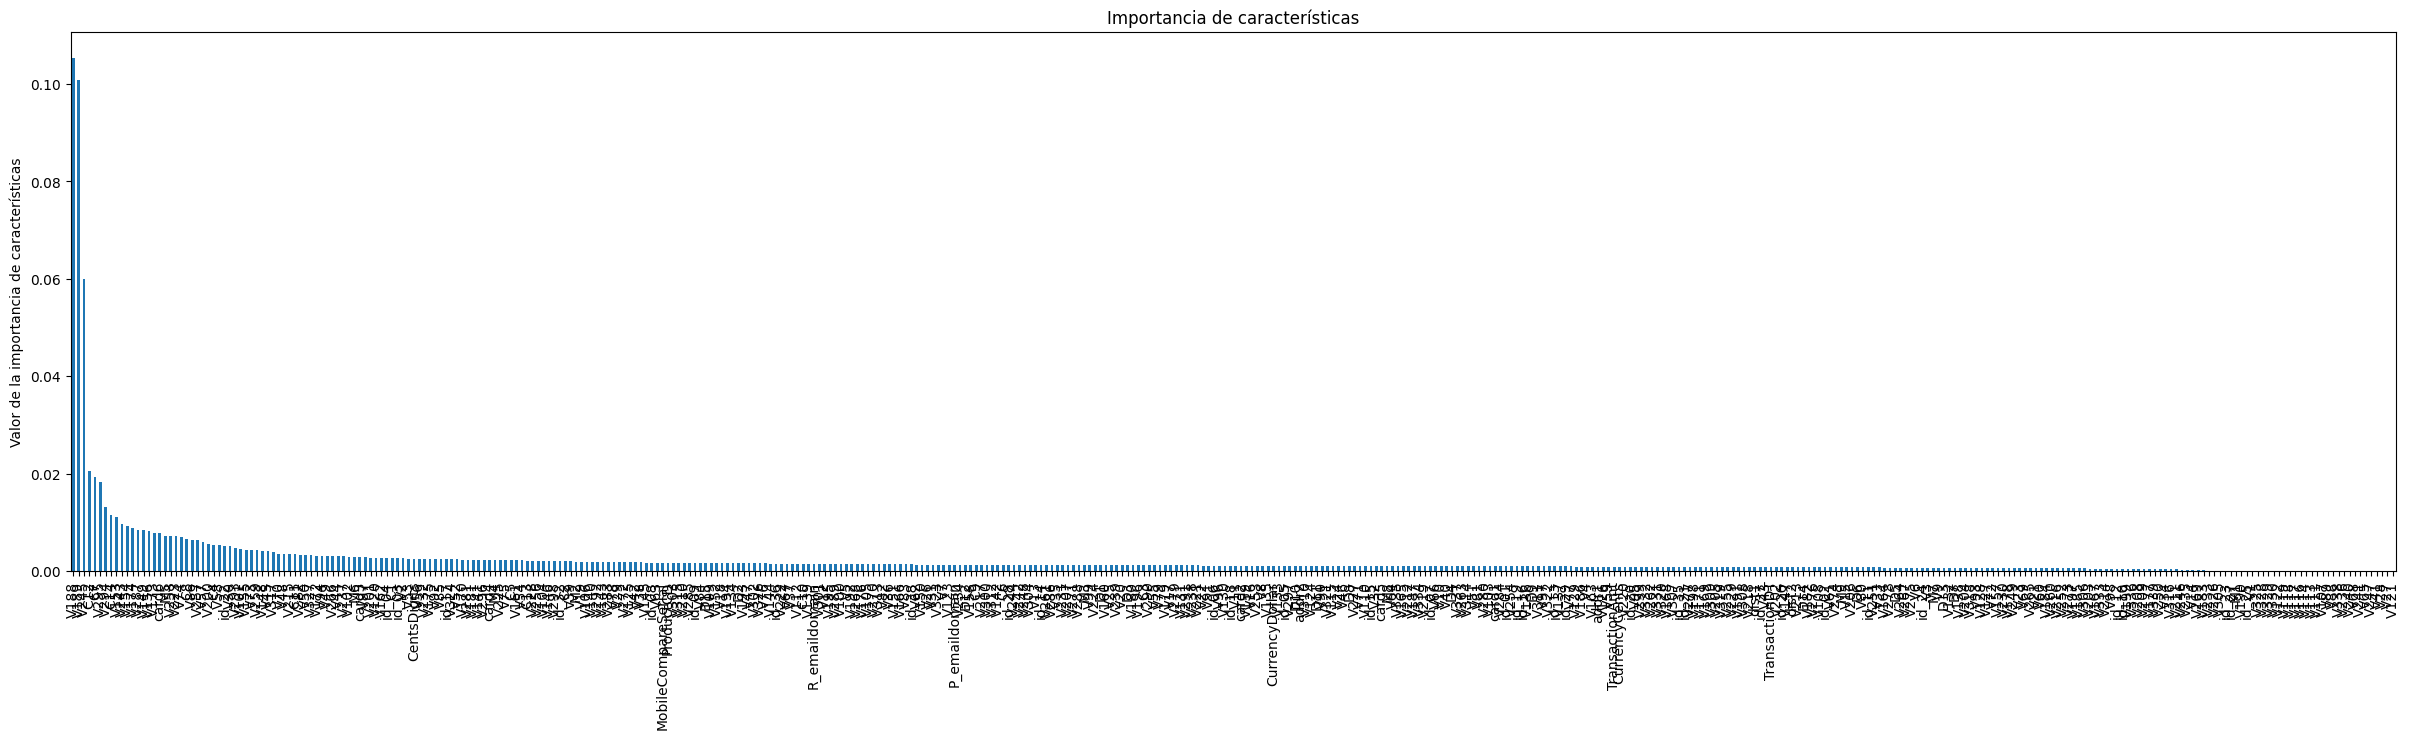

In [ ]:
plt.figure(figsize=(30,7))

predictors=list(X_train)
feat_imp = pd.Series(model2.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importancia de características')
plt.ylabel('Valor de la importancia de características')
print('Precisión de GBM en el dataset de prueba: {:.3f}'.format(model2.score(X_test, y_test)))
pred=model2.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
feat_imp

V188    0.105351
V189    0.100780
V245    0.059926
C12     0.020629
C7      0.019213
          ...   
V247    0.000000
V41     0.000000
V28     0.000000
V27     0.000000
V121    0.000000
Length: 430, dtype: float32

Text(0, 0.5, 'Valor de la importancia de características')

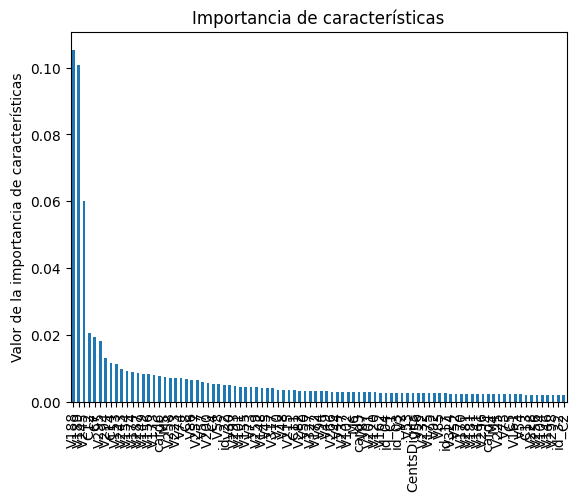

In [ ]:
features002=feat_imp.loc[feat_imp > 0.002]
features002.plot(kind='bar', title='Importancia de características')
plt.ylabel('Valor de la importancia de características')

In [ ]:
feat_imp.loc[feat_imp > 0.01]

V188    0.105351
V189    0.100780
V245    0.059926
C12     0.020629
C7      0.019213
V295    0.018193
V294    0.013119
C14     0.011559
V153    0.011168
dtype: float32

As a conclusion of this exercise, the following is highlighted: The XGBoost model was better able to predict fraudulent labels, equivalent to only 15%. On the other hand, it is noted that when scaling with normalization training is performed with both GradientBoosting and XGBoost, the code execution time takes longer than when scaling with StandardScaler.